In [1]:
%matplotlib inline


基于卷积神经网络的生成对抗网络 DCGAN
==============

本教程改编自PyTorch[官方教程](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)。


生成对抗网络 (Generative Adversarial Nets, GAN)
------------------------------------------------


GAN 是一种深度学习模型，根据训练数据的统计分布，用于生成新的数据。GAN 由 Ian Goodfellow 于2014年提出，相关论文为[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).
GAN包括两个子网络，一个是生成器 (generator), 一个是鉴别器(discriminator)。生成器用于合成图像，使之与训练集中的真实图像看起来一样。鉴别器用于区分图像是训练集中的真实图像，还是生成器合成的图像。在训练过程中，生成器与鉴别器相互“博弈”，生成器尽量生成可以迷惑鉴别器的图像，而鉴别器尽量给出图像真假的准确判定。

令$x$ 表示一个图像，可以是训练集中的真实图像，或是生成器合成的图像，图像数据维度（通道数，高度，宽度）为3x64x64。$D(x)$ 为鉴别器，对输入图像给出是否为真实图像的概率数值。概率数值接近于1表示为真实图像，概率数值接近于0表示为合成图像。

对于生成器，令$z$ 为一个从标准多元正态分布中采样得到的向量，$G(z)$ 将 $z$ 映射为图像数据。训练集样本的分布为$p_{data}$，生成器合成的样本分布为$p_g$。

将生成器合成的图像送入鉴别器，$D(G(z))$ 给出该图像属于真实图像的概率值。

生成对抗网络的目标函数为：
$$
\begin{align}\underset{G}{\text{min}} \space \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}
$$

鉴别器的目的是让上式所示的目标函数最大化，生成器的目的是让该目标函数最小化。

基于卷积神经网络的生成对抗网络DCGAN
---------------------------------

DCGAN中的生成器采用转置卷积层实现，鉴别器采用卷积层实现。由Radford等人在[Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)论文中提出。 

下面我们通过程序看一下DCGAN的实现过程。首先载入函数库。

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


输入
------

输入数据定义如下:

-  **dataroot** - 存放数据集根目录
-  **workers** - 使用DataLoader加载数据的工作线程数
-  **batch_size** - 批量大小
-  **image_size** - 图像的高度和宽度，默认为 64x64. 如果更改图像尺寸大小，生成器和鉴别器的网络结构也需要相应调整，具体参见[相关说明](https://github.com/pytorch/examples/issues/70)
-  **nc** - 图像通道数，彩色图像通道数为3
-  **nz** - 隐变量$z$的维度
-  **ngf** - 生成器中特征图通道数调整参数
-  **ndf** - 鉴别器中特征图通道数调整参数
-  **num_epochs** - 训练轮数
-  **lr** - 学习率，DCGAN论文中采用的学习率为 0.0002
-  **beta1** - Adam 优化器中的超参数，DCGAN论文中采用0.5
-  **ngpu** - 可使用的GPU个数。设为0时，采用CPU运行

In [3]:
# Root directory for dataset
dataroot = "data/test/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

数据集
------

本教程采用的数据集为MNIST测试集。数据目录为当前目录下的 "data/test"子目录。

我们使用 ImageFolder 数据集处理类装载数据。

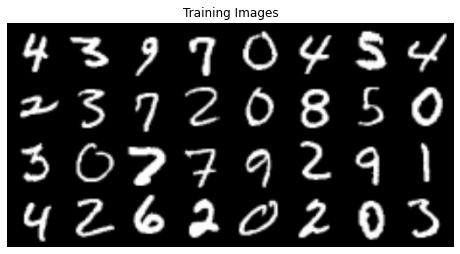

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

实现
-----
我们先看一下权值初始化策略，再设计生成器和鉴别器，然后给出损失函数和训练流程。

权值初始化
----------

在DCGAN论文中，权值采用正态分布随机初始化方法，用于卷积层、转置卷积层、批量归一化层等初始化。

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

生成器
------

生成器$G$将隐变量$z$映射为图像数据,即生成RGB彩色图像(3x64x64)。生成器由二维转置卷积层、二维批量归一化层和ReLU激活函数组成。生成器最终输出送入Tanh激活函数，得到 $[-1,1]$ 的数值范围，与输入图像经过预处理后的数值范围一致。


<img src="g.png" width="600"/>



In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

我们设计了生成器，并调用``weights_init`` 函数初始化，生成器模型结构打印信息如下：

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


鉴别器
-------

鉴别器 $D$ 完成一个两分类任务，对输入图像给出真假的判别结果。鉴别器的输入为 3x64x64 的彩色图像。鉴别器由二维卷积层、二维批量归一化层和LeakyReLU激活函数组成，最后通过Sigmoid 激活函数得到二分类判别的概率结果。

鉴别器代码实现如下：

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

我们设计了鉴别器，并调用``weights_init`` 函数初始化，鉴别器模型结构打印信息如下：

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


损失函数和优化器
---------------

真实图像类别标签为1，合成图像类别标签为0.
损失函数为二值交叉熵 [Binary Cross Entropy loss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)。
损失函数为:

$$
\begin{align}
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}
$$

我们为生成器$G$和鉴别器$D$分别设计一个优化器。优化器均采用Adam优化器，学习率为 0.0002，超参数Beta1 为 0.5。
生成器的输入为从正态分布中采样得到的隐变量，每批次数目为Batch_Size。

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

训练
----

训练过程分为两个部分，第一部分更新鉴别器，第二部分更新生成器。

训练过程显示的统计信息包括：

-  **Loss_D** - 鉴别器的损失函数，包括各批次真实图像和合成图像的损失函数之和
-  **Loss_G** - 生成器的损失函数
-  **D(x)** - 鉴别器对真实样本的判别平均概率输出
-  **D(G(z))** - 鉴别器对合成样本的判别平均概率输出

**注:** 训练可能需要更多轮数才能达到预期结果。

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True)) 
            
        iters += 1

Starting Training Loop...
[0/2][0/313]	Loss_D: 1.8127	Loss_G: 4.6878	D(x): 0.5157	D(G(z)): 0.5644 / 0.0106
[0/2][100/313]	Loss_D: 0.1959	Loss_G: 14.5702	D(x): 0.9751	D(G(z)): 0.1353 / 0.0000
[0/2][200/313]	Loss_D: 1.2379	Loss_G: 2.4340	D(x): 0.3880	D(G(z)): 0.0000 / 0.1313
[0/2][300/313]	Loss_D: 0.0423	Loss_G: 4.4345	D(x): 0.9807	D(G(z)): 0.0219 / 0.0185
[1/2][0/313]	Loss_D: 0.0765	Loss_G: 4.3879	D(x): 0.9588	D(G(z)): 0.0318 / 0.0170
[1/2][100/313]	Loss_D: 0.2612	Loss_G: 2.3393	D(x): 0.8135	D(G(z)): 0.0207 / 0.1466
[1/2][200/313]	Loss_D: 0.3291	Loss_G: 5.2974	D(x): 0.9660	D(G(z)): 0.2324 / 0.0069
[1/2][300/313]	Loss_D: 0.1224	Loss_G: 3.1668	D(x): 0.9212	D(G(z)): 0.0366 / 0.0626


结果
------

首先我们可视化显示训练过程中，鉴别器和生成器损失变化情况。其次，我们显示生成器输出的结果。然后我们比较一个批次的真实数据和合成数据。

**训练过程中各迭代步骤的损失变化**

下图是鉴别器 $D$ 和生成器 $G$ 各迭代步骤损失变化情况。

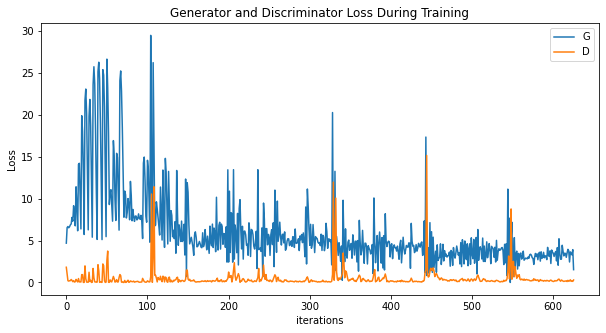

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**生成器输出可视化**

每一轮生成器的输出可视化结果为：（若训练轮数多于1，可查看动画效果）


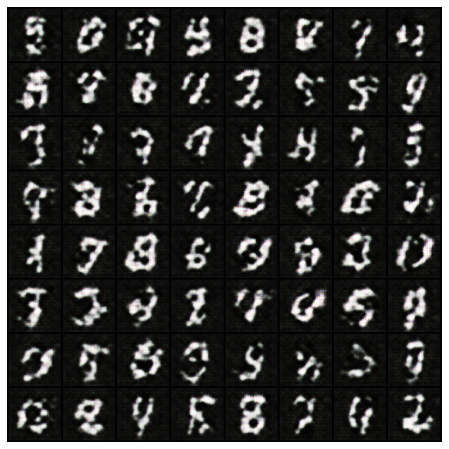

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**真实图像与合成图像的比较**

我们对比一下真实图像与合成图像的效果：


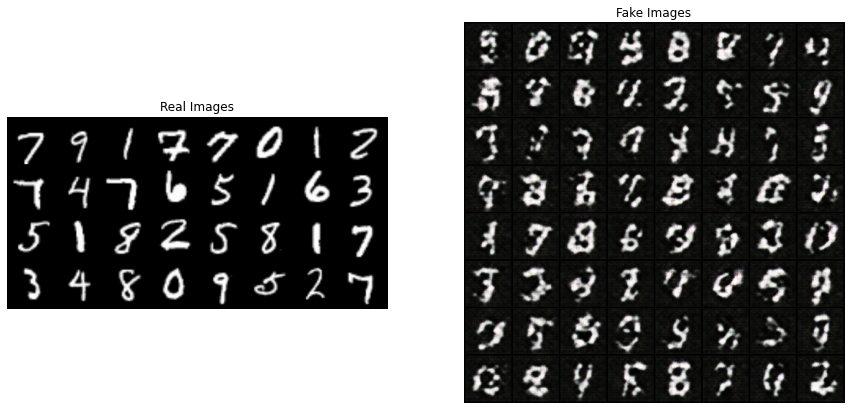

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

进一步的工作
----------------

我们还可以进一步尝试:

-  训练更多的轮数，查看合成图像的效果
-  更改模型结构，使之适用于其他尺寸的输入图像
-  查看其他[与GAN相关的项目](https://github.com/nashory/gans-awesome-applications)
-  尝试可以[生成音乐的GAN](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio/)


